In [ ]:
from google.colab import drive
import torch

drive.mount('mount/')
device = torch.device("cuda:0" if (torch.cuda.is_available()) else "cpu")
print(device)

Mounted at mount/
cuda:0


In [ ]:
from torch.utils.data import Dataset
import os

class AudioMNIST(Dataset):
  def __init__(self, wav, mask):
    self.wav = wav # wave path
    self.mask = mask # mask path
    self.len = len(os.listdir(self.wav))

  def __getitem__(self, index):
    ls_wav = sorted(os.listdir(self.wav))
    ls_mask = sorted(os.listdir(self.mask))

    wav_file_path = os.path.join(self.wav, ls_wav[index])
    wav_tensor = torch.load(wav_file_path)

    mask_file_path = os.path.join(self.mask, ls_mask[index])
    mask_tensor = torch.load(mask_file_path)

    return wav_tensor, mask_tensor

  def __len__(self):
    return self.len  

train = AudioMNIST('mount/MyDrive/audiomnist/train/wav/', 'mount/MyDrive/audiomnist/train/mask/')
test = AudioMNIST('mount/MyDrive/audiomnist/test/wav/', 'mount/MyDrive/audiomnist/test/mask/')

In [ ]:
import random
import torch.nn.functional as F

batch_size = 50

traindataloader = torch.utils.data.DataLoader(train, batch_size=batch_size, shuffle=True, pin_memory=True)
testdataloader = torch.utils.data.DataLoader(test, batch_size=batch_size, shuffle=True, pin_memory=True)

torch.Size([17, 13, 1])


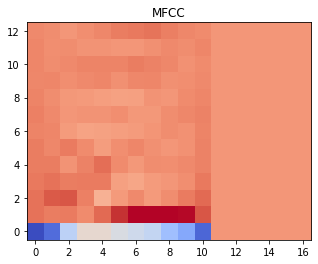

0


In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from matplotlib import cm

fig, ax = plt.subplots()
print(train[0][0].size())
mfcc_data= np.swapaxes(train[0][0].squeeze().numpy(), 0 ,1)
cax = ax.imshow(mfcc_data, interpolation='nearest', cmap=cm.coolwarm, origin='lower')
ax.set_title('MFCC')
plt.show()
print(train[0][1])

In [ ]:
class EncoderRNN(torch.nn.Module):
    def __init__(self, input_size, hidden_size):
        super(EncoderRNN, self).__init__()
        self.hidden_size = hidden_size
        self.embedding = torch.nn.Embedding(input_size, self.hidden_size)
        self.gru = torch.nn.GRU(input_size, self.hidden_size, batch_first=True, bidirectional=True)
        self.lin = torch.nn.Sequential(torch.nn.Linear(2*self.hidden_size, int(0.25*self.hidden_size)),
                                    torch.nn.LeakyReLU(0.2, inplace=False),
                                    torch.nn.Linear(int(0.25*self.hidden_size), int(0.0625*self.hidden_size)),
                                    torch.nn.LeakyReLU(0.2, inplace=False),
                                    torch.nn.Linear(int(0.0625*self.hidden_size), 10))

    def forward(self, input):
        latent, hidden = self.gru(input)
        latent = latent[:, -1, :]
        output = self.lin(latent)
        return output

In [ ]:
hidden_size = 128
n_mfcc = 13

encoder = EncoderRNN(n_mfcc, hidden_size).to(device)

optimizer = torch.optim.Adam(encoder.parameters(), lr=0.002, amsgrad=True)
criterion = torch.nn.CrossEntropyLoss()

In [ ]:
train_loss_history = []
test_loss_history = []
train_acc_history = []
test_acc_history = []

In [ ]:
from tqdm import tqdm
best_loss = 1
steps = 15

for epoch in range(steps):
    train_loss = 0.0
    test_loss = 0.0
    train_acc = 0.0
    test_acc = 0.0

    for i, data in enumerate(tqdm(traindataloader)):
        encoder.train()
        wav, tag = data
        wav = wav.cuda()
        tag = tag.cuda()
        optimizer.zero_grad()
        pred = encoder(wav.squeeze()).cuda()
        loss = criterion(pred, tag)
        loss.backward()
        optimizer.step()
        #scheduler.step(epoch + i / len(trainDataLoader))
        train_loss += loss.item()/len(traindataloader)
        train_acc += (torch.eq(torch.max(pred, 1)[1], tag).sum()/len(tag)*100).data.cpu().numpy()

    for i, data in enumerate(tqdm(testdataloader)):
        encoder.eval()
        with torch.no_grad():
            wav, tag = data
            wav = wav.cuda()
            tag = tag.cuda()
            pred = encoder(wav.squeeze()).cuda()
            loss = criterion(pred, tag)
            test_loss += loss.item()/len(testdataloader)
            test_acc += (torch.eq(torch.max(pred, 1)[1], tag).sum()/len(tag)*100).data.cpu().numpy()

    train_loss_history.append(train_loss)
    test_loss_history.append(test_loss)
    train_acc_history.append(train_acc/len(traindataloader))
    test_acc_history.append(test_acc/len(testdataloader))

    if test_loss < best_loss:
        best_loss = test_loss
        torch.save(encoder.state_dict(), 'mount/MyDrive/encoder.pt')

    print('Epoch %s, Train loss %s, Test loss %s, Train accuracy %s, Test accuracy %s,'
        %(epoch, train_loss, test_loss, train_acc/len(traindataloader), test_acc/len(testdataloader)))
  
    if test_acc/len(testdataloader) >= 99.8:
        break

100%|██████████| 20/20 [02:13<00:00,  6.66s/it]


Epoch 0, Train loss 2.2294522374868393, Test loss 2.0609480798244477, Train accuracy 13.499999725818634, Test accuracy 18.699999856948853,


100%|██████████| 20/20 [00:24<00:00,  1.21s/it]


Epoch 1, Train loss 1.5951706178486353, Test loss 1.08377465903759, Train accuracy 37.57499918937683, Test accuracy 60.599999237060544,


100%|██████████| 20/20 [00:24<00:00,  1.22s/it]


Epoch 2, Train loss 0.7990779004991054, Test loss 0.5541278541088104, Train accuracy 69.92499904632568, Test accuracy 78.09999771118164,


100%|██████████| 20/20 [00:24<00:00,  1.23s/it]


Epoch 3, Train loss 0.4970802560448646, Test loss 0.42411669045686723, Train accuracy 80.39999771118164, Test accuracy 82.39999771118164,


100%|██████████| 20/20 [00:24<00:00,  1.21s/it]


Epoch 4, Train loss 0.3158787671476604, Test loss 0.25362068787217135, Train accuracy 87.79999723434449, Test accuracy 92.49999732971192,


100%|██████████| 20/20 [00:23<00:00,  1.18s/it]


Epoch 5, Train loss 0.2173262542113662, Test loss 0.17552376762032507, Train accuracy 92.0749979019165, Test accuracy 93.69999809265137,


100%|██████████| 20/20 [00:24<00:00,  1.20s/it]


Epoch 6, Train loss 0.14766377948690207, Test loss 0.1267583546228707, Train accuracy 95.4749969482422, Test accuracy 96.69999694824219,


100%|██████████| 20/20 [00:23<00:00,  1.17s/it]


Epoch 7, Train loss 0.10083882829640059, Test loss 0.10683318935334682, Train accuracy 96.57499723434448, Test accuracy 96.99999771118163,


100%|██████████| 20/20 [00:23<00:00,  1.19s/it]


Epoch 8, Train loss 0.08587201167829338, Test loss 0.08820207836106418, Train accuracy 97.37499704360962, Test accuracy 98.29999694824218,


100%|██████████| 20/20 [00:24<00:00,  1.22s/it]


Epoch 9, Train loss 0.0967553085647523, Test loss 0.14889333955943584, Train accuracy 96.97499656677246, Test accuracy 96.19999694824219,


100%|██████████| 20/20 [00:24<00:00,  1.22s/it]


Epoch 10, Train loss 0.07247164200525731, Test loss 0.07322935496922583, Train accuracy 97.59999704360962, Test accuracy 98.69999771118164,


100%|██████████| 20/20 [00:24<00:00,  1.23s/it]


Epoch 11, Train loss 0.08248781875299757, Test loss 0.2949078308418393, Train accuracy 97.69999742507935, Test accuracy 93.89999694824219,


100%|██████████| 20/20 [00:24<00:00,  1.20s/it]


Epoch 12, Train loss 0.07741763327503579, Test loss 0.05584311217535288, Train accuracy 97.64999761581421, Test accuracy 99.19999771118164,


100%|██████████| 20/20 [00:23<00:00,  1.19s/it]


Epoch 13, Train loss 0.031211162218824025, Test loss 0.026029323029797526, Train accuracy 98.99999752044678, Test accuracy 99.39999847412109,


100%|██████████| 20/20 [00:24<00:00,  1.21s/it]

Epoch 14, Train loss 0.029880047775804996, Test loss 0.05497707773465663, Train accuracy 98.94999723434448, Test accuracy 99.09999809265136,


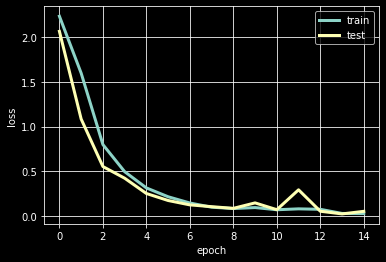

In [ ]:
plt.style.use("dark_background")
plt.plot(range(len(train_loss_history)),train_loss_history,'-',linewidth=3,label='train')
plt.plot(range(len(test_loss_history)),test_loss_history,'-',linewidth=3,label='test')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.grid(True)
plt.legend()

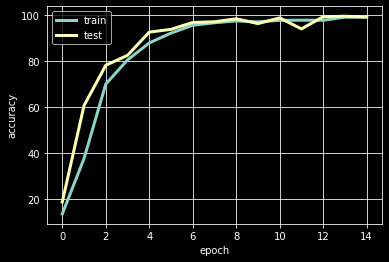

In [ ]:
plt.style.use("dark_background")
plt.plot(range(len(train_acc_history)),train_acc_history,'-',linewidth=3,label='train')
plt.plot(range(len(test_acc_history)),test_acc_history,'-',linewidth=3,label='test')
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.grid(True)
plt.legend()